#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# импортируем все нужные библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots

from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    cross_val_score,
    GridSearchCV
)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error

# зададим параметры окна вывода графиков
plt.rcParams["figure.figsize"] = (15,7)

In [2]:
# считываем исходные данные из файла csv, записываем дату в индекс
try:
    df_taxi = pd.read_csv('/datasets/taxi.csv', sep=',', index_col=[0], parse_dates=[0])
except:
    df_taxi = pd.read_csv('c:/users/bny_7/datasets/taxi.csv', sep=',', index_col=[0], parse_dates=[0])

In [3]:
# отсортируем данные по индексу (дате) и отобразим содержимое набора данных
df_taxi.sort_index(inplace=True)
display(df_taxi.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Исходные данные представляют собой временной ряд. Интервал данных составляет 10 минут.

Посмотрим на общее описание данных и проверим пропуски и дубли

In [4]:
display(df_taxi.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

26496 строк в таблице и 26496 не пустых значений, следовательно, пропуски в данных отсутвуют.
Количество заказов - целое число, как и должно быть.      
Посмотрим на общую статистику таблицы.

In [5]:
display(df_taxi['num_orders'].describe())

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

Фиксируем, что в поле количества заказов **присутствуют 0-е значения**.    
Подсчитаем их количество.

In [6]:
display(df_taxi.query('num_orders==0').count())

num_orders    537
dtype: int64

Таких записей оказалось 537 штук, но в данном случае это допустимо, потому что в какие-то интервалы действительно могло и не быть заказов, так что ничего удалять не будем.

Посмотрим на даты.

In [7]:
display(df_taxi.index.min(),df_taxi.index.max())

Timestamp('2018-03-01 00:00:00')

Timestamp('2018-08-31 23:50:00')

У нас в наборе данные за **период с 1 марта 2018 по 31 августа 2018 года**.    

Теперь проверим дублирование записей.

In [8]:
display(f'Дублированных строк без учета индекса: {df_taxi.duplicated().sum()}')
display(f'Дублированных индексов: {df_taxi.index.duplicated().sum()}')

'Дублированных строк без учета индекса: 26415'

'Дублированных индексов: 0'

In [9]:
# проверим наши индексы на монотонность
df_taxi.index.is_monotonic

True

Получается, что дублей в индексах нет, их последовательность монотонна, то есть они отсортированы по порядку, а дублирование количества заказов нас не интересует, потому что в нашем случае это нормально.

Промежуточный вывод по результатам предварительного анализа данных:    
- количество записей составляет 26496,
- пропусков в данных нет,
- дублирования данных нет,
- данные представлены за период 1 марта 2018 по 31 августа 2018 года,
- минимальное количество поездок равно 0, максимальное - 119,
- аномальных значений нет.

Знакомство с данными мы провели, теперь **перейдем к их ресемплингу на интервалы в 1 час и исследованию**, чтобы подготовиться к построению модели машинного обучения.

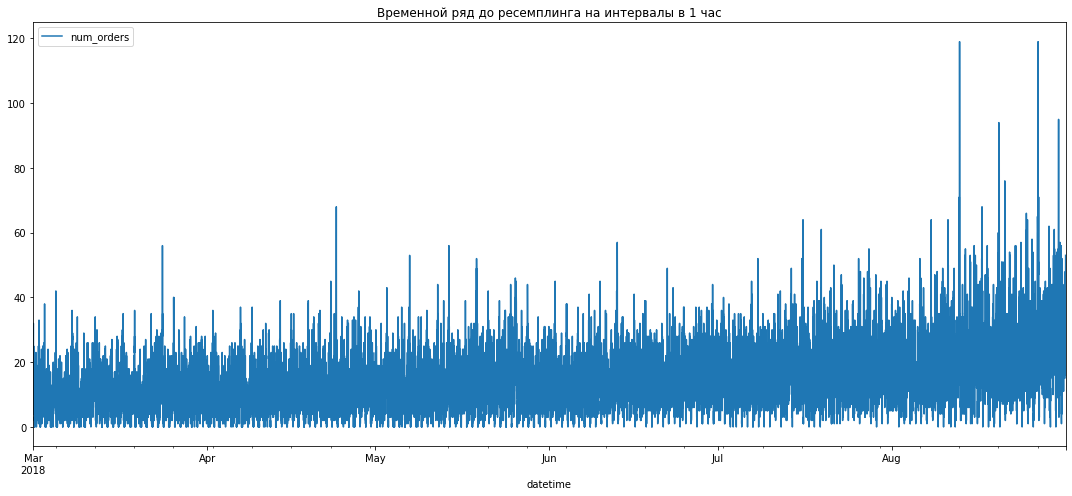

In [10]:
# строим график временного ряда
df_taxi.plot(ax=plt.gca())
plt.title('Временной ряд до ресемплинга на интервалы в 1 час')
plt.tight_layout()

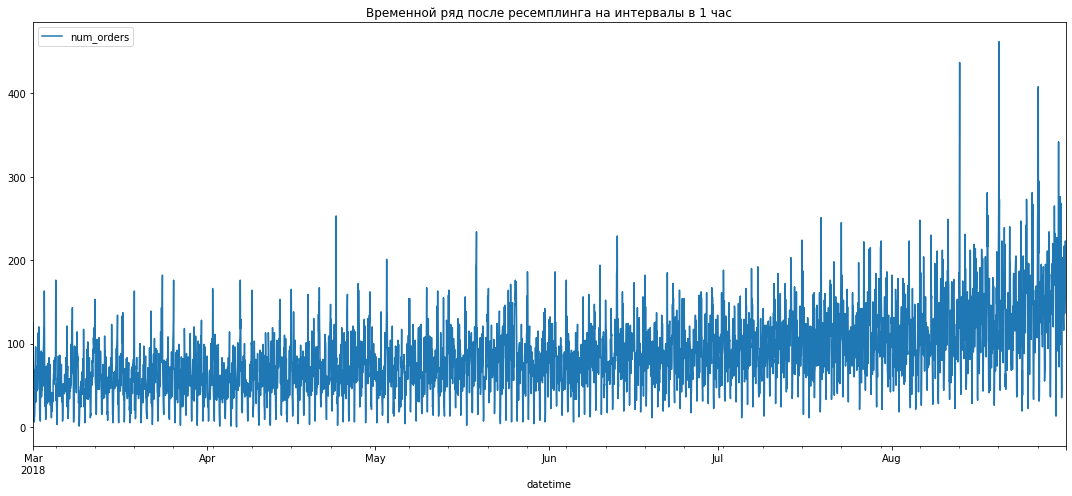

In [11]:
df_taxi_res = df_taxi.resample('1h').sum()
df_taxi_res.plot(ax=plt.gca())
plt.title('Временной ряд после ресемплинга на интервалы в 1 час')
plt.tight_layout()

Посмотрим на статистику данных после ресемплинга

In [12]:
# посмотрим на статистику данных
display(df_taxi_res.describe())

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [13]:
# посмотрим на общую информацию
display(df_taxi_res.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

Итоговый вывод по результатам загрузки данных и предобработки:
- количество записей после ресемплинга сократилось с 26496 до 4416,
- пропусков в данных и пустых значений нет,
- данные представлены за период 1 марта 2018 по 31 августа 2018 года,
- количество поездок:
    - до ресемплинга за период в 10 минут от 0 до 119,
    - после ресемплинга за период в 1 час от 0 до 462,
- аномальных значений нет.

## Анализ

Определим, стационарен ли наш ряд. Для этого используем тест Дики-Фулера.

In [14]:
# проведем тест Дики-Фуллера, чтобы определить природу нашего исходного ряда
st_test = adfuller(df_taxi_res['num_orders'], regression='ctt')

if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Наш ряд стационарный


Далее вычислим скользящее среднее для нашего ряда и посмотрим на тренды и сезонность данных.

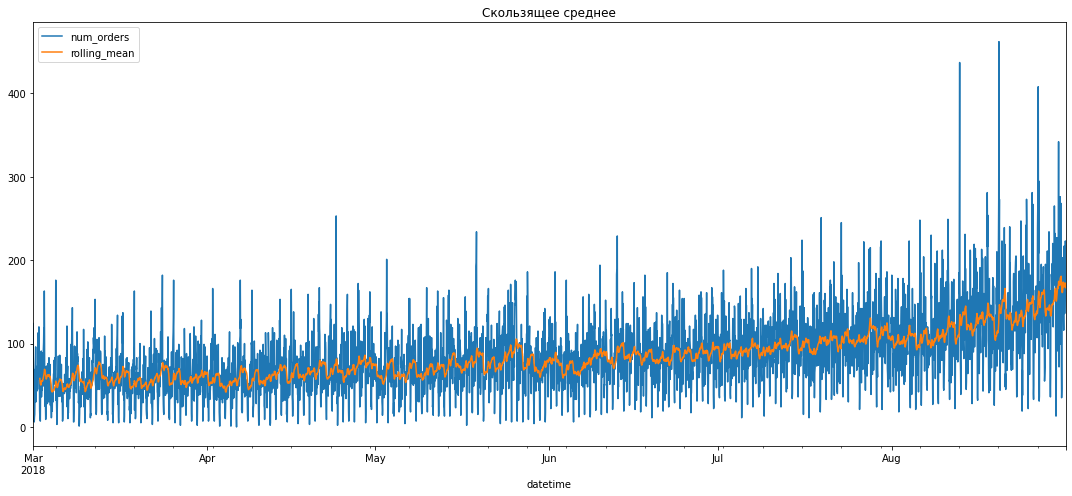

In [15]:
# вычисляем скользящее среднее
taxi_temp = df_taxi_res.copy()
taxi_temp['rolling_mean'] = taxi_temp.rolling(30).mean()
taxi_temp.plot(ax=plt.gca())
plt.title('Скользящее среднее')
plt.tight_layout()

Видим, что среднее количество заказов растет от марта к августу. Делаем вывод, что наш ряд нестационарный.

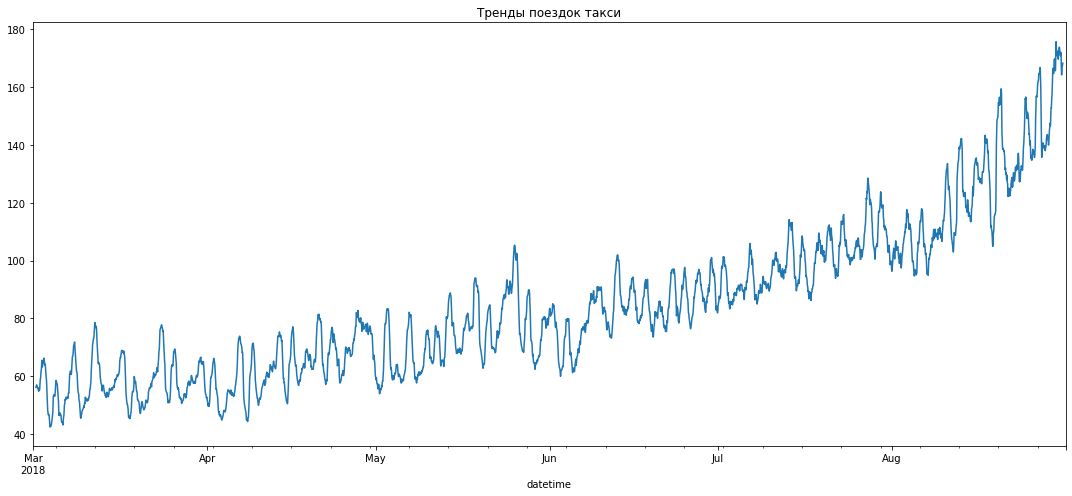

In [16]:
# посмотрим на тренды
decomposed = seasonal_decompose(df_taxi_res)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренды поездок такси')
plt.tight_layout()

Видим тренд на увеличение количества поездок на такси от марта к августу.

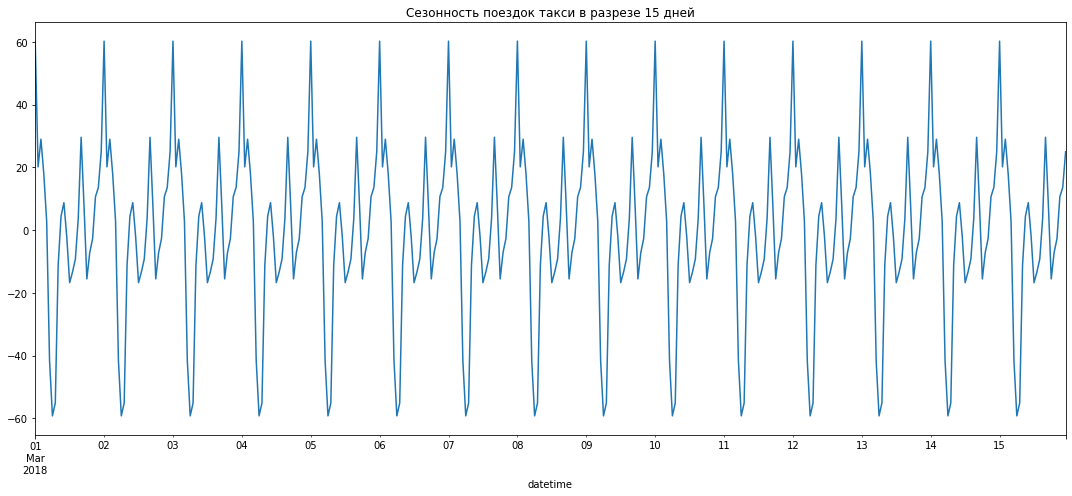

In [17]:
# посмотрим на сезонность в разрезе месяца
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Сезонность поездок такси в разрезе 15 дней')
plt.tight_layout()

Сезонность выше, чем 1 день, увеличим масштаб, чтобы ее рассмотреть

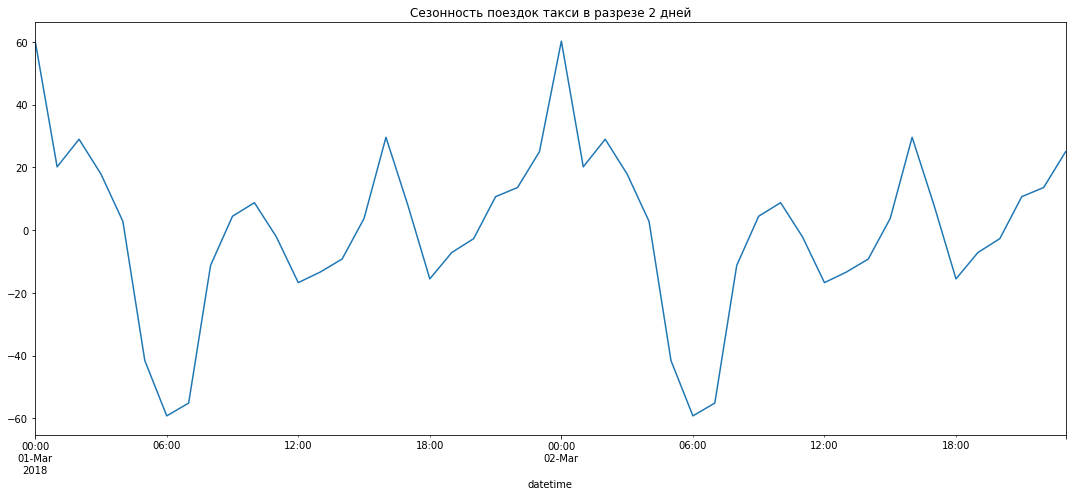

In [18]:
# посмотрим на сезонность в разрезе дня
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Сезонность поездок такси в разрезе 2 дней')
plt.tight_layout()

Видим, что пик приходится на 24:00, затем идет резкий спад до 06:00 и опять начинается рост спроса с провалами в 12:00 и 18:00.    
Поскольку наш ряд нестационарный, то рассчитаем временную разность, чтобы сделать его более стационарным.

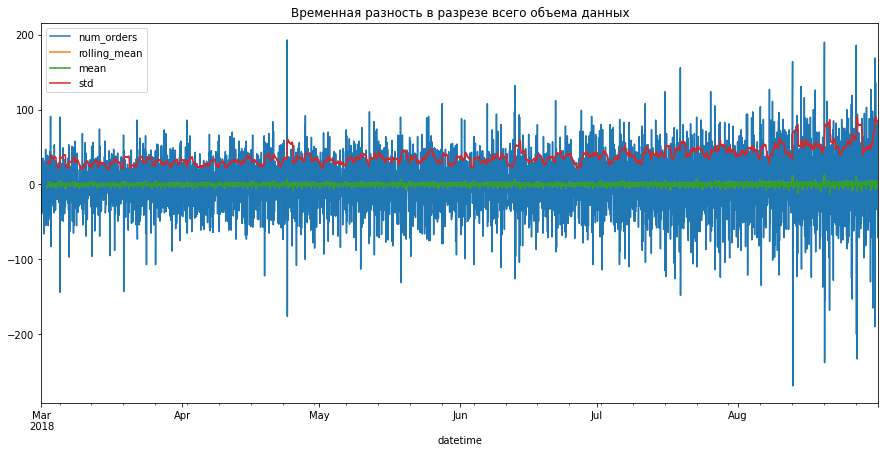

In [19]:
# рассчитаем временную разность
taxi_temp = taxi_temp - taxi_temp.shift()
taxi_temp['mean'] = taxi_temp['num_orders'].rolling(30).mean()
taxi_temp['std'] = taxi_temp['num_orders'].rolling(30).std()
taxi_temp.plot(ax=plt.gca())
plt.title('Временная разность в разрезе всего объема данных')
plt.show()

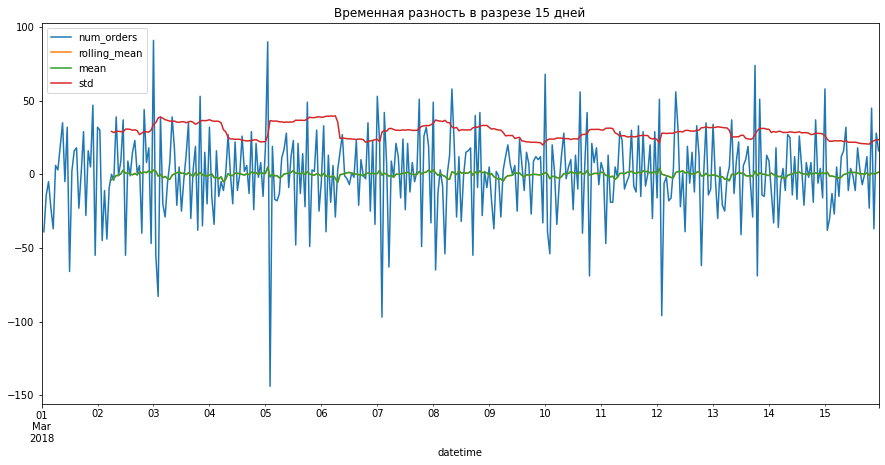

In [20]:
# увеличим масштаб, чтобы рассмотреть график
taxi_temp['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('Временная разность в разрезе 15 дней')
plt.show()

**Выводы:**
- наблюдается тренд на рост числа заказов от марта к августу,
- наблюдается сезонность: пик приходится на 24:00, затем идет резкий спад до 06:00 и опять начинается рост спроса с провалами в 12:00 и 18:00,
- тестом Дики-Фулера мы определили, что наш ряд стационарный, проигнорировав заметный рост числа заказов в августе, но тем не менее будем учить модель на данных с временной разностью.

In [21]:
# код ревьювера
from statsmodels.tsa.stattools import adfuller

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()

ts = taxi['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')



Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


## Обучение

Обучим следующие модели:
- LinearRegression,
- DecisionTreeRegressor,
- CatBoostRegressor.

Создадим функцию, которая будет добавлять дополнительные признаки, необходимые модели для обучения. Поскольку выше мы установили, что наша сезонность суточная, то в качестве дополнительного признака мы добавим день и час.

In [22]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [23]:
# создаем признаки с помощью функции и задаем параметры
MAX_LAG = 24
ROLLING_MEAN_SIZE = 24
RANDOM_STATE = 42
make_features(df_taxi_res, MAX_LAG, ROLLING_MEAN_SIZE)

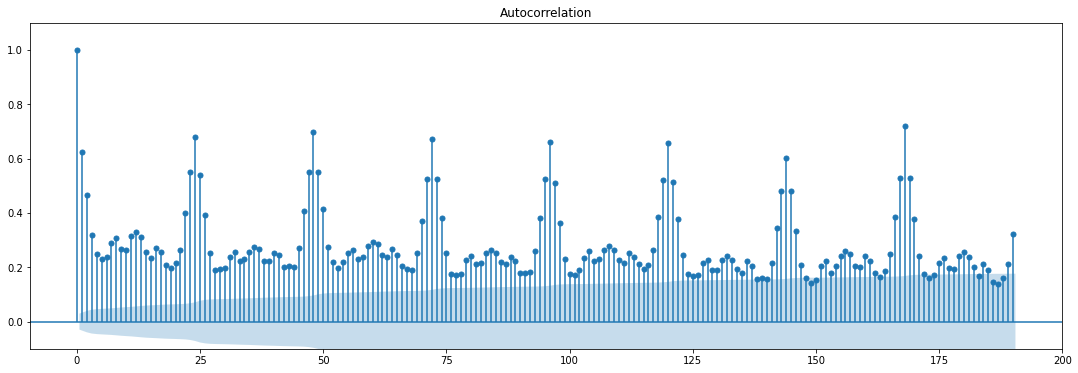

In [24]:
# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 



In [25]:
# делим наши данные на тренировочную и тестовую выборки
train, test = train_test_split(df_taxi_res, shuffle=False, test_size=0.1)
train = train.dropna()

In [26]:
# напечатаем индексы выборок, чтобы проверить деление
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Деление прошло корректно.

In [27]:
# делим наши данные на тренировочную и тестовую выборки
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

Для поиска лучшей модели воспользуемся кросс-валидацией для временных рядов.

In [28]:
tscv = TimeSeriesSplit(n_splits=5)

### Модель линейной регрессии

In [29]:
model_lr = LinearRegression()
param_search_lr = {}

In [30]:
grid_lr = GridSearchCV(estimator=model_lr, cv=tscv, param_grid=param_search_lr, scoring= 'neg_mean_squared_error')
grid_lr.fit(X_test, y_test)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LinearRegression(), param_grid={},
             scoring='neg_mean_squared_error')

In [31]:
# выводим на экран параметры лучшей модели для LinearRegression
print('Лучшая модель и её параметры:\n\n', grid_lr.best_estimator_)
print (f'Метрика MSE лучшей модели, полученная кросс-валидацией: {grid_lr.best_score_: .2f}')
print (f'Метрика RMSE лучшей модели, полученная кросс-валидацией: {(grid_lr.best_score_*-1)**0.5: .2f}')

Лучшая модель и её параметры:

 LinearRegression()
Метрика MSE лучшей модели, полученная кросс-валидацией: -2164.82
Метрика RMSE лучшей модели, полученная кросс-валидацией:  46.53


**RMSE на кросс-валидации: 46.53**

### Модель дерева решений

In [32]:
model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)
param_search_dtr = {
    'criterion':['friedman_mse'],
    'max_depth':range(2,7),
    'min_samples_leaf':range(2,7)    
}

In [33]:
grid_dtr = GridSearchCV(estimator=model_dtr, cv=tscv, param_grid=param_search_dtr, scoring= 'neg_mean_squared_error')
grid_dtr.fit(X_test, y_test)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'criterion': ['friedman_mse'],
                         'max_depth': range(2, 7),
                         'min_samples_leaf': range(2, 7)},
             scoring='neg_mean_squared_error')

In [34]:
# выводим на экран параметры лучшей модели для LinearRegression
print('Лучшая модель и её параметры:\n\n', grid_dtr.best_estimator_)
print (f'Метрика MSE лучшей модели, полученная кросс-валидацией: {grid_dtr.best_score_: .2f}')
print (f'Метрика RMSE лучшей модели, полученная кросс-валидацией: {(grid_dtr.best_score_*-1)**0.5: .2f}')

Лучшая модель и её параметры:

 DecisionTreeRegressor(criterion='friedman_mse', max_depth=4, min_samples_leaf=5,
                      random_state=42)
Метрика MSE лучшей модели, полученная кросс-валидацией: -2247.51
Метрика RMSE лучшей модели, полученная кросс-валидацией:  47.41


**RMSE на кросс-валидации: 47.51**

### Модель CatBoostRegressor

In [35]:
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE)
param_search_cbr = {
    'learning_rate':[0.5]    
}

In [36]:
grid_cbr = GridSearchCV(estimator=model_cbr, cv=tscv, param_grid=param_search_cbr,
                        verbose=False, scoring= 'neg_mean_squared_error')
grid_cbr.fit(X_test, y_test)

0:	learn: 40.1183668	total: 49.1ms	remaining: 49s
1:	learn: 34.1527529	total: 50.9ms	remaining: 25.4s
2:	learn: 29.6275231	total: 52.6ms	remaining: 17.5s
3:	learn: 25.8254792	total: 54.3ms	remaining: 13.5s
4:	learn: 23.7323698	total: 56ms	remaining: 11.1s
5:	learn: 20.4608465	total: 57.7ms	remaining: 9.56s
6:	learn: 17.7875514	total: 59.4ms	remaining: 8.43s
7:	learn: 16.1212564	total: 61.1ms	remaining: 7.57s
8:	learn: 14.3642561	total: 62.8ms	remaining: 6.92s
9:	learn: 12.9782729	total: 64.6ms	remaining: 6.39s
10:	learn: 12.2800625	total: 66.3ms	remaining: 5.96s
11:	learn: 10.6494140	total: 67.9ms	remaining: 5.59s
12:	learn: 9.0604415	total: 69.7ms	remaining: 5.29s
13:	learn: 8.3365907	total: 71.5ms	remaining: 5.03s
14:	learn: 7.4547641	total: 73.3ms	remaining: 4.82s
15:	learn: 6.4677274	total: 75ms	remaining: 4.61s
16:	learn: 5.7755987	total: 76.7ms	remaining: 4.44s
17:	learn: 4.9682600	total: 78.6ms	remaining: 4.29s
18:	learn: 4.7460196	total: 80.3ms	remaining: 4.15s
19:	learn: 4.048

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f193ddddc40>,
             param_grid={'learning_rate': [0.5]},
             scoring='neg_mean_squared_error', verbose=False)

In [37]:
# выводим на экран параметры лучшей модели для LinearRegression
print('Лучшая модель и её параметры:\n\n', grid_cbr.best_estimator_)
print (f'Метрика MSE лучшей модели, полученная кросс-валидацией: {grid_cbr.best_score_: .2f}')
print (f'Метрика RMSE лучшей модели, полученная кросс-валидацией: {(grid_cbr.best_score_*-1)**0.5: .2f}')

Лучшая модель и её параметры:

Метрика MSE лучшей модели, полученная кросс-валидацией: -2213.03
Метрика RMSE лучшей модели, полученная кросс-валидацией:  47.04


**RMSE на кросс-валидации: 47.04**

Сведем результаты наших изысканий в одну таблицу, чтобы сделать вывод

In [38]:
display(
    pd.DataFrame([round((grid_lr.best_score_*-1)**0.5,2),
              round((grid_dtr.best_score_*-1)**0.5,2),
              round((grid_cbr.best_score_*-1)**0.5,2)],
              index=['LinearRegression','DecisionTreeRegression','CatBoostRegression'],
              columns=['RMSE']).sort_index(ascending=False)
       )

,RMSE
LinearRegression,46.53
DecisionTreeRegression,47.41
CatBoostRegression,47.04


**Вывод:**
Лучший результат показала **линейная модель** без дополнительных параметров с **rmse = 46.53**

## Тестирование LinearRegression

In [39]:
# рассчитаем предсказания выбранной моделью и сравним с истинными
y_pred = grid_lr.best_estimator_.predict(X_test)

# вычисляем значение rmse
rmse = round(mean_squared_error(y_test, y_pred)**0.5,2)
print(f'RMSE тестовой выборки {rmse}')

RMSE тестовой выборки 41.64


На тестовой выборке линейная модель показала ошибку, удовлетворяющую условию задания, - менее 48.

No handles with labels found to put in legend.


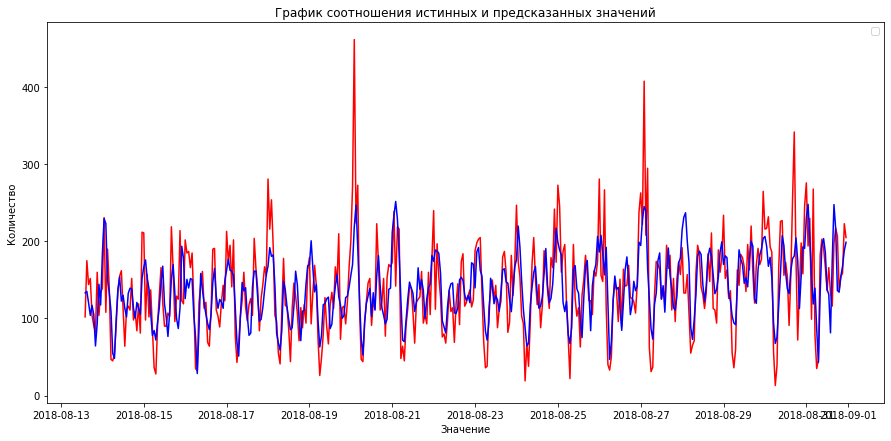

In [40]:
# отобразим тестовые и предсказанные данные на графике
plt.plot(y_test.index, y_test, '-r',
         y_test.index, y_pred, '-b')
ax=plt.gca()
ax.set_title('График соотношения истинных и предсказанных значений')
ax.set_xlabel('Значение')
ax.set_ylabel('Количество')
ax.legend(loc ='upper right')
plt.show()

Из графика видим, что предсказания модели чаще заниженные, поэтому водителей по-прежнему может не хватить.    
Посмотрим на важность признаков.

In [41]:
feature_importance = grid_lr.best_estimator_.coef_
feature_names = X_test.columns

In [42]:
feat_imp = pd.DataFrame(feature_importance,
                        index = feature_names,
                        columns=['importance'])

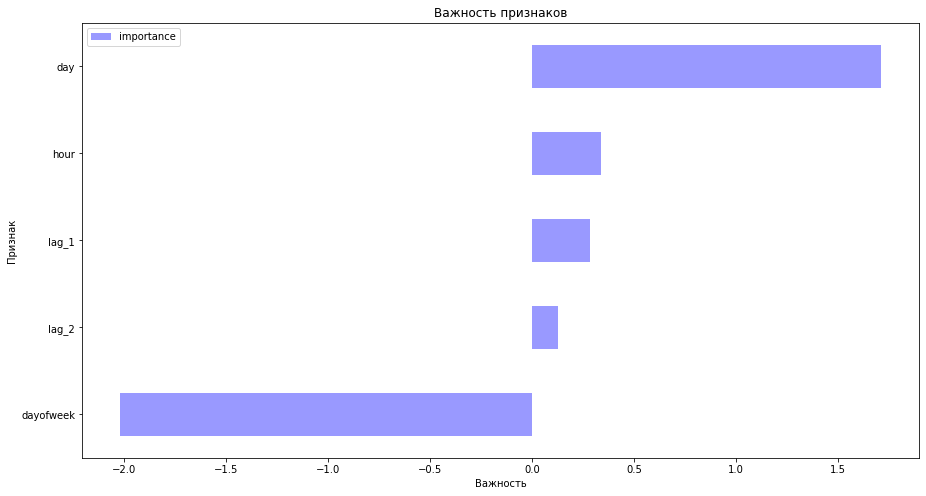

In [43]:
# Отобразим на графике важность признаков
plt.rcParams["figure.figsize"] = (15,8)
ax=feat_imp[:5].sort_values('importance').plot(kind ='barh', color='blue', alpha=0.4)
ax.set_title('Важность признаков')
ax.set_xlabel('Важность')
ax.set_ylabel('Признак')
plt.show()

Из графика видим, что большой вес (важность) у дня месяца, часа и полей с временной разницей 1 и 2 часа.

In [45]:
# подсчитаем среднюю ошибку прогноза
print(f'Средняя ошибка прогноза составляет: {round(abs((y_pred-y_test)).mean())} заказ')

Средняя ошибка прогноза составляет: 31 заказ


**Вывод:** выбранные признаки для построения модели позволили построить модель, которая в среднем ошибается на 31 заказ.

**Общие выводы:**     
1. Проведен анализ предоставленных заказчиком  данных о заказх такси в аэропорт.     
2. Поскольку исходные данные являются временным рядом, то в ходе предобработки и исследования проведен ресемплинг до 1 часа, на который мы и должны сделать прогноз:
    - дубли отсутствуют,
    - аномальные значения отсутствуют,
    - пропуски отсутствуют.
3. Создана функция, которая рассчитывает дополнительные признаки для обучения модели: временные сдвиги, день месяца и час.
4. Выбраны 3 модели для предсказания количества заказов:
    - LinearRegression,
    - DecisionTreeRegressor,
    - CatBoostRegressor.
5. Подобраны гиперпараметры для двух последних выбранных моделей, а линейная регрессия взята без дополнительных настроек.
6. В качестве показателя точности построения модели выбрана ошибка RMSE, которая определялась на кросс-валидации для временных рядов.
7. По результатам сравнения построенных моделей выбрана модель LinearRegression спуска, чьи прогнозы оказались ближе всех к истинным и ошибка на тестовых данных соответствовала условиям задачи (rmse<=48).
8. Проведен анализ важности признаков модели, построен график сравнения предсказаний и истинных значений. Самыми важными признаками оказались:
    - день месяца,
    - час,
    - сдвиг на 1 час,
    - сдвиг на 2 часа.
9. Средняя недооценка количества заказов построенной моделью составляет 31.    